## Análise preliminar da distribuição dos dados

15 de agosto de 2023

---

Com este notebook, objetiva-se a exploração da distribuição de dados no conjunto ao qual será implementado o algoritmo de k-means. Esta exploração tem caráter preliminar, e deverá apresentar a distribuição de dados, estatísticas e outras informações que nos levem a compreender o insumo que temos.

Em relação ao dataset, parte-se de algumas premissas:

- os dados foram coletados por meio do Portal de Dados Abertos da Alesp, sendo assim registros oficiais;
- os valores foram corrigidos conforme a inflação de cada período até dezembro de 2022, seguindo metodologia do Banco Central e índices disponibilizados pelo IBGE;
- os dados se referem a despesas de alimentação e hospedagem, apenas;
- cada linha é um registro de despesa único.

À análise:

In [1]:
# carregamento das bibliotecas necessárias
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [2]:
# carregamento do dataset
df = pd.read_csv("../data/2013_2022_corrigido.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34197 entries, 0 to 34196
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Data             34197 non-null  object 
 1   CNPJ             32833 non-null  float64
 2   Valor            34197 non-null  float64
 3   Valor_corrigido  34197 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


O dataset é composto de 4 colunas (uma do tipo `object` ou `string`; as demais do tipo `float`) e 34.197 linhas. `CNPJ` contém alguns valores nulos &mdash; como esta é uma variável importante para a aplicação futura de k-means, valores nulos devem ser desconsiderados. Além disso, é preciso converter `CNPJ` para o tipo `string`, pois trata-se de variável categórica.

In [3]:
# exclusão de nulos
df = df[df['CNPJ'].notnull()]

# conversão de tipo
df['CNPJ'] = df['CNPJ'].astype(str)

Observemos a quantidade de registros por ano:

In [4]:
# cópia do dataframe
df_ano = df.copy()

# conversão de tipo
df_ano['Data'] = pd.to_datetime(df_ano['Data'])

# agrupamento e cálculos
df_ano.groupby(df_ano['Data'].dt.year).agg({'Valor_corrigido': ['sum', 'count', 'mean']})

Valor_corrigido                  
                 sum count        mean
Data                                  
2013      1212551.57  4313  281.138783
2014      1064279.73  4047  262.979918
2015      1061466.58  3731  284.499217
2016       863261.28  3190  270.614821
2017      1034897.63  3425  302.159892
2018       931806.30  3098  300.776727
2019      1047596.58  3403  307.845013
2020       350773.85  1435  244.441707
2021       816510.19  2782  293.497552
2022       988979.78  3409  290.108472

Aqui temos algumas informações interessantes:

- 2013 foi o ano com maior valor total, e também com a maior quantidade de despesas. Com isso, a média por despesa não figura entre os maiores valores;
- em 2019 a quantidade de despesas foi semelhante a 2022, mas o valor médio por despesa foi pouco mais de R\\$ 17 superior.

Para este estudo, utilizaremos somente os dados de 2022. E vamos tomar apenas duas colunas: `CNPJ` e `Vamor_corrigido`.

In [5]:
# filtro a partir do ano
df = df[df['Data'].str.startswith('2022')].reset_index()

# remoção de colunas desnecessárias
data = df[['CNPJ', 'Valor_corrigido']]

# apresentação de resultados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3409 entries, 0 to 3408
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CNPJ             3409 non-null   object 
 1   Valor_corrigido  3409 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.4+ KB


In [6]:
# contagem de valores únicos
data['CNPJ'].nunique()

1580

In [7]:
# descrição estatística dos dados
data['Valor_corrigido'].describe()

count     3409.000000
mean       290.108472
std        596.307449
min          0.000000
25%         55.650000
50%        129.320000
75%        285.200000
max      10250.410000
Name: Valor_corrigido, dtype: float64

Os 3.409 registros de 2022 mostram que há 1.580 CNPJs únicos. Anteriormente vimos que essas 3.409 despesas somam R\\$ 988.979,78. Cada despesa tem o valor médio de R\\$ 290,11 &mdash; entretanto, o desvio-padrão é elevado, indicando significativa dispersão dos dados em relação à média.

Notamos ainda que a média é superior ao terceiro quartil (Q3). Isso indica que o conjunto de dados está inclinado para valores mais baixos, apesar da significante presença de outliers, que puxa o Q3 para cima. Graficamente, o valor médio maior que o Q3 sugere assimetria positiva: a cauda do lado direito  é mais longa do que do lado esquerdo.

Vamos ver essa dispersão em gráficos:r.

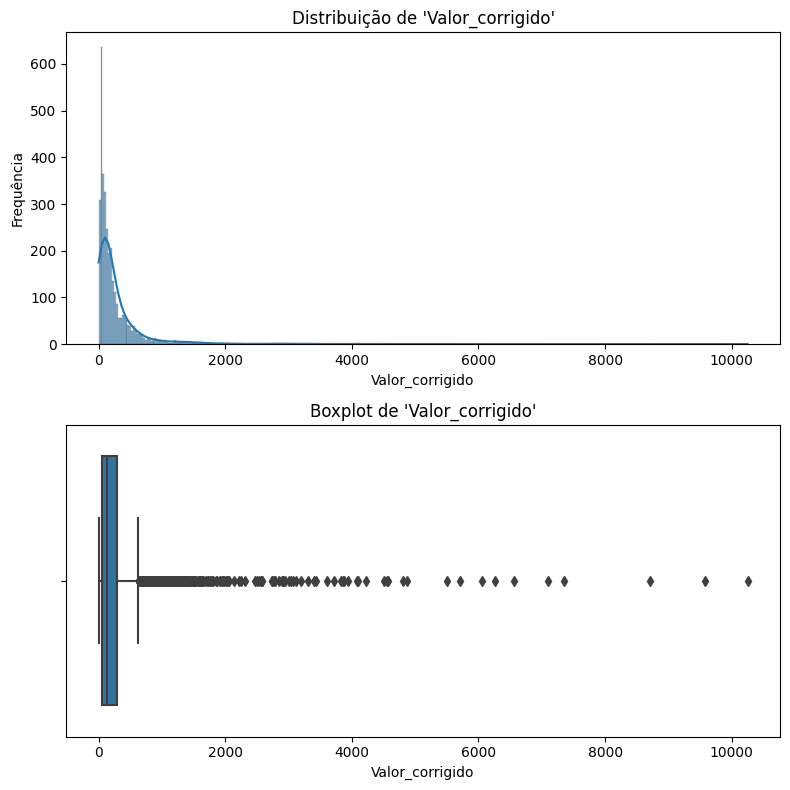

In [8]:
# determinação da disposição dos gráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# criação de histograma
sns.histplot(data['Valor_corrigido'], kde=True, ax=axes[0])
axes[0].set_title("Distribuição de 'Valor_corrigido'")
axes[0].set_xlabel('Valor_corrigido')
axes[0].set_ylabel('Frequência')

# criação de boxplot
sns.boxplot(x=data['Valor_corrigido'], ax=axes[1])
axes[1].set_title("Boxplot de 'Valor_corrigido'")
axes[1].set_xlabel('Valor_corrigido')

# apresentação
plt.tight_layout()
plt.show()

O histograma mostra que `Valor_corrigido` está inclinado para a direita, com concentração de valores mais baixos: conforme os valores aumentam, a densidade diminui.

Já boxplot confirma a presença de outliers na distribuição. O intervalo interquartil é estreito em comparação com a amplitude de todo o dataset, o que indica que a maioria dos dados se concentra num intervalo pequeno e mais próximo dos menores valores.

Observemos, então, coeficiente de variação, assimetria e curtose.o

In [9]:
# cálculo de coeficiente de variação
cv = data['Valor_corrigido'].std() / data['Valor_corrigido'].mean()

# cálculo de assimetria e curtose
data_skewness = skew(data['Valor_corrigido'])
data_kurtosis = kurtosis(data['Valor_corrigido'])

# organização de resultados
resultados = {
    'coeficiente de variação (%)': cv,
    'assimetria': data_skewness,
    'curtose': data_kurtosis
}

# apresentação
resultados

{'coeficiente de variação (%)': 2.055463756963658,
 'assimetria': 7.612963936851333,
 'curtose': 83.7187725360396}

O coeficiente de variação de 205,5% indica alto grau de variabilidade relativo à média. A assimetria de 7,6 confirma a inclinação à direita, enquanto a curtose de 83,7 comprova cauda longa e picos acentuados em comparação à distribuição normal.